# Cardiovascular Risk Prediction — EDA & Model Comparison

This notebook performs:
1. Basic exploratory data analysis (EDA) on the processed cardiovascular dataset.
2. A simple comparison of several baseline models (Logistic Regression, Random Forest, MLP, and optionally XGBoost) on one of the 5 data folds.

Data files are expected to be located under `../data/` in the following format:
- `cardio_exp{fold}_train.csv`
- `cardio_exp{fold}_val.csv`
- `cardio_exp{fold}_test.csv`


In [1]:
# If `umap-learn` is not installed, uncomment the next line.
# Note: requires internet access.
try:
    import umap  # noqa: F401
except Exception as e:
    print("UMAP not found. Attempting to install...")
    try:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "umap-learn"])
        import umap  # retry
        print("Installed `umap-learn`. You can rerun the notebook now.")
    except Exception as e2:
        print("Installation failed. Please `pip install umap-learn` manually in your environment.")

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


DATA_DIR = Path("..") / "data"
assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR.resolve()}"
DATA_DIR


WindowsPath('../data')

In [3]:
FOLD = 0  

train_path = DATA_DIR / f"cardio_exp{FOLD}_train.csv"
val_path   = DATA_DIR / f"cardio_exp{FOLD}_val.csv"
test_path  = DATA_DIR / f"cardio_exp{FOLD}_test.csv"

train = pd.read_csv(train_path)
val   = pd.read_csv(val_path)
test  = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Val shape:  ", val.shape)
print("Test shape: ", test.shape)

train.head()


Train shape: (41215, 16)
Val shape:   (13739, 16)
Test shape:  (13739, 16)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,cv_fold
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,3
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,2
2,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,4
3,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177,3
4,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60,29.384676,4


In [4]:
def add_derived_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # age_years
    if "age_years" not in df.columns and "age" in df.columns:
        df["age_years"] = df["age"] / 365.25

    # bmi
    if "bmi" not in df.columns and {"height", "weight"}.issubset(df.columns):
        height_m = df["height"] / 100.0
        df["bmi"] = df["weight"] / (height_m ** 2)

    return df

train = add_derived_features(train)
val   = add_derived_features(val)
test  = add_derived_features(test)

train[["age", "age_years", "height", "weight", "bmi"]].head()


,age,age_years,height,weight,bmi
0,18393,50,168,62.0,21.967120
1,20228,55,156,85.0,34.927679
2,17623,48,169,82.0,28.710479
3,17474,48,156,56.0,23.011177
4,21914,60,151,67.0,29.384676


Label distribution in TRAIN:


,proportion
cardio,
0,0.505277
1,0.494723


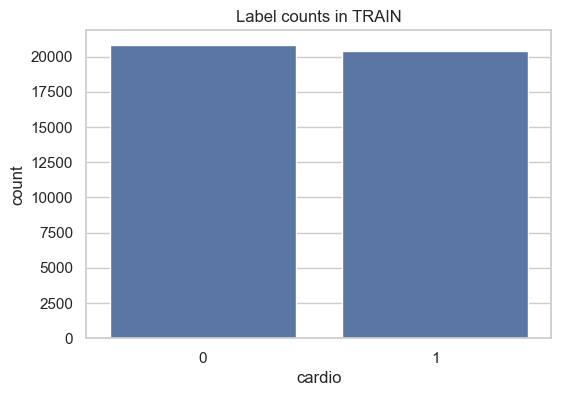

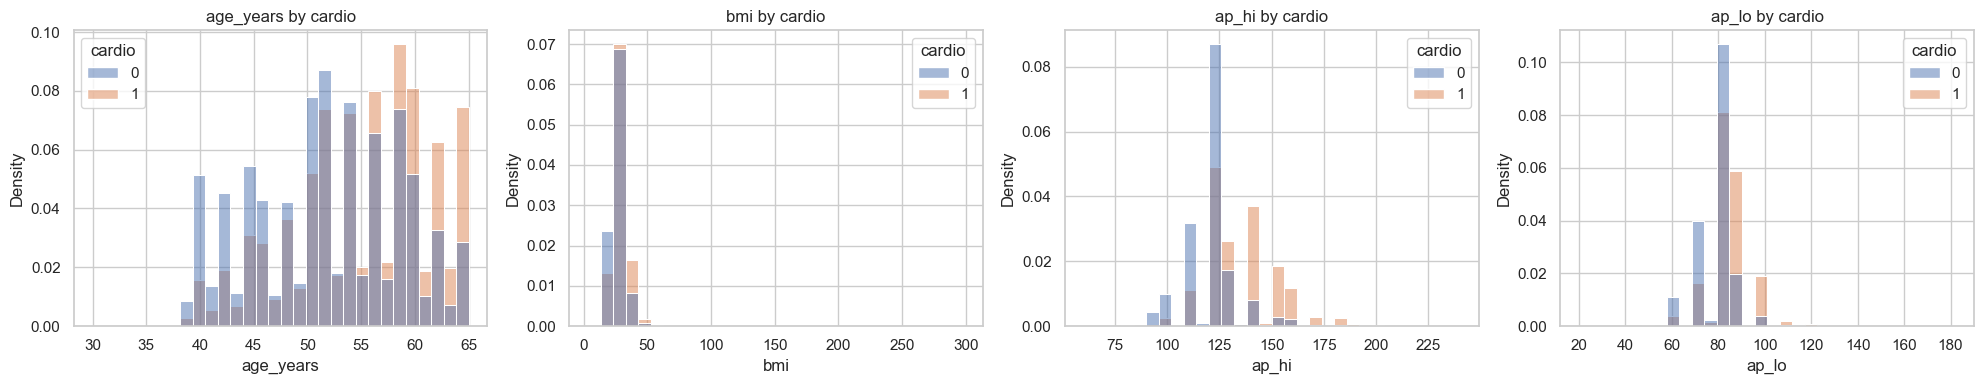

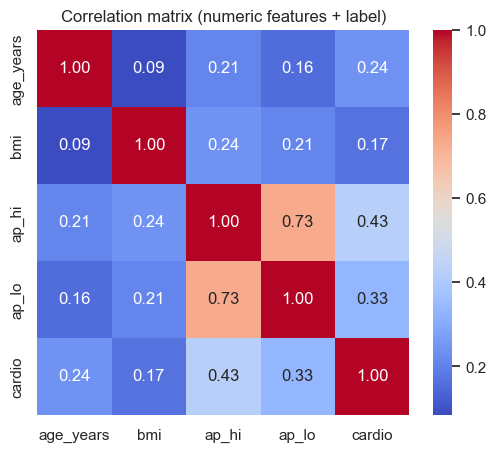

In [5]:
target_col = "cardio"
assert target_col in train.columns, f"{target_col} not found in train columns"


label_counts = train[target_col].value_counts(normalize=True).sort_index()
print("Label distribution in TRAIN:")
display(label_counts.to_frame("proportion"))

fig, ax = plt.subplots()
sns.countplot(data=train, x=target_col, ax=ax)
ax.set_title("Label counts in TRAIN")
plt.show()


num_for_plot = [c for c in ["age_years", "bmi", "ap_hi", "ap_lo"] if c in train.columns]
fig, axes = plt.subplots(1, len(num_for_plot), figsize=(5 * len(num_for_plot), 4))

if len(num_for_plot) == 1:
    axes = [axes]

for ax, col in zip(axes, num_for_plot):
    sns.histplot(data=train, x=col, hue=target_col, bins=30,
                 stat="density", common_norm=False, ax=ax)
    ax.set_title(f"{col} by {target_col}")
plt.tight_layout()
plt.show()

num_cols_corr = [c for c in num_for_plot if c in train.columns] + [target_col]
corr = train[num_cols_corr].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix (numeric features + label)")
plt.show()


In [6]:

drop_cols = [target_col, "id", "cv_fold"]
feature_cols = [c for c in train.columns if c not in drop_cols]

preferred_num_cols = ["age_years", "bmi", "ap_hi", "ap_lo"]
num_cols = [c for c in preferred_num_cols if c in feature_cols]

other_cols = [c for c in feature_cols if c not in num_cols]

print("Numeric cols:", num_cols)
print("Other cols:  ", other_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("other", "passthrough", other_cols),
    ]
)

X_train, y_train = train[feature_cols], train[target_col]
X_val,   y_val   = val[feature_cols],   val[target_col]


Numeric cols: ['age_years', 'bmi', 'ap_hi', 'ap_lo']
Other cols:   ['age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


In [7]:
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight=None,
        solver="lbfgs",
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=100,
        random_state=42,
    ),
}

if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )

results = []

for name, clf in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", clf),
        ]
    )

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_val)

    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_val)[:, 1]
    else:
        y_proba = None

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba) if y_proba is not None else np.nan

    results.append(
        {
            "model": name,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "auc": auc,
        }
    )

results_df = pd.DataFrame(results).set_index("model").sort_values("auc", ascending=False)
results_df


,accuracy,precision,recall,f1,auc
model,,,,,
XGBoost,0.733969,0.744248,0.704281,0.723713,0.800343
LogisticRegression,0.727200,0.747363,0.677652,0.710802,0.793412
RandomForest,0.721304,0.720440,0.713550,0.716978,0.779550
MLP,0.544799,0.521140,0.984699,0.681568,0.775320
